In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from tqdm.auto import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
# import nltk
# from nltk.corpus import stopwords

import spacy
nlp = spacy.load("en_core_web_sm")

from collections import Counter
from typing import List

import string
import re

import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 1

# nltk.download('stopwords')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
text = df_train['text'].tolist()
text[:5]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']

In [8]:
targets = df_train['target'].tolist()
targets[:5]

[1, 1, 1, 1, 1]

In [9]:
from torchtext.vocab import GloVe

glove = GloVe(name='6B', dim=300)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.39MB/s]                               
100%|█████████▉| 399999/400000 [01:07<00:00, 5951.87it/s]


In [10]:
def text_processing(text: list, test: bool = False, vocab_size: int = None, pretrained: bool = False) -> set[list, set]:
    

    tokens = []
    sentences = []
        
    print('text tokenizing...')
    for sent in tqdm(text):
        doc = nlp(sent)
        processed_text = [token.text.lower() for token in doc 
                                         if not token.is_punct 
                                         and not token.is_space 
#                                          and not token.is_stop 
                                         and not token.is_digit 
                                         and not token.like_url 
                                         and not token.like_email 
#                                          and not token.is_oov
                                         and token.is_alpha
                         ]
        tokens.append(processed_text)
    if test:
        return [' '.join(sent) for sent in tokens]
        
    print('words counting...')
    word_counter = Counter()
    for sent in tqdm(tokens):
        for word in sent:
            word_counter[word] += 1
        sentences.append(' '.join(sent))
        
    if pretrained:
        glove.stoi['<pad>'] = len(glove.stoi)
        vocab = glove.stoi
        print("Всего слов в словаре:", len(vocab))
        return sentences, vocab
    
    print('vocab forming...')
    vocab = set()
    if vocab_size:
        vocab = set(dict(sorted(word_counter.items(), key=lambda x: x[1], reverse=True)[:vocab_size]).keys())
    else:
        vocab_size = len(word_counter)
        vocab = set(dict(word_counter).keys())
    vocab.add('<pad>')
    print("Всего слов в словаре:", len(vocab))
    return sentences, vocab

print('--train dataset--')
sentences, vocab = text_processing(text, pretrained=True)
print('--test dataset--')
test_sentences = text_processing(df_test['text'].tolist(), test=True)

--train dataset--
text tokenizing...


  0%|          | 0/7613 [00:00<?, ?it/s]

words counting...


  0%|          | 0/7613 [00:00<?, ?it/s]

Всего слов в словаре: 400001
--test dataset--
text tokenizing...


  0%|          | 0/3263 [00:00<?, ?it/s]

In [11]:
df_train['sentences'] = sentences
df_train.head()

,id,keyword,location,text,target,sentences
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [12]:
df_test['sentences'] = test_sentences
df_test.head()

,id,keyword,location,text,sentences
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills in china and taiwan


In [13]:
# vocab['<pad>'] = len(vocab)
word2ind = vocab
# word2ind = {word: i for i, word in enumerate(vocab)}
# ind2word = {i: word for word, i in word2ind.items()}

In [14]:
word2ind['<pad>'], vocab['<pad>']

(400000, 400000)

In [15]:
class WordDataset:
    def __init__(self, inputs):
        self.data = list(inputs['sentences'])
        self.labels = list(inputs['target'])
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [word2ind[word] for word in word_tokenize(self.data[idx])
                                     if word in vocab]
        return tokenized_sentence, self.labels[idx]

    def __len__(self) -> int:
        return len(self.data)
    
def collate_fn(batch):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    max_len = max([len(x) for x in data])
    data = [x + [word2ind['<pad>']] * (max_len - len(x)) for x in data]
    return [torch.LongTensor(data), torch.LongTensor(labels)]

In [16]:
class WordTestDataset:
    def __init__(self, inputs):
        self.data = list(inputs['sentences'])
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [word2ind[word] for word in word_tokenize(self.data[idx])
                                     if word in vocab]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)
    
def test_collate_fn(batch):
    data = [item for item in batch]
    max_len = max([len(x) for x in data])
    data = [x + [word2ind['<pad>']] * (max_len - len(x)) for x in data]
    return torch.LongTensor(data)

In [17]:
train_inputs, val_inputs = train_test_split(df_train[['sentences', 'target']], test_size=0.2, stratify=df_train[['target']])
test_inputs = df_test[['sentences']]

train_dataset = WordDataset(train_inputs)
val_dataset = WordDataset(val_inputs)
test_dataset = WordTestDataset(test_inputs)

batch_size = 512

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=collate_fn)

val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, collate_fn=collate_fn)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, collate_fn=test_collate_fn)

In [18]:
for inputs, labels in train_dataloader:
    print(inputs[0])
    print(inputs.shape)
    print(labels[0])
    print(labels.shape)
    break


tensor([   330,   1469,   1611,   1503,     10,    233,    860,  18179,  13091,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000])
torch.Size([512, 28])
tensor(0)
torch.Size([512])


In [19]:
for inputs in test_dataloader:
    print(inputs[0])
    print(inputs.shape)
    break


tensor([   120,   1579,      7,   5510,    569,   2005, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000])
torch.Size([512, 28])


In [20]:
def evaluate(model, criterion, dataloader) -> tuple[float, float]:
    model.eval()
    accuracies = []
    losses = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f'Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            preds = logits.argmax(dim=1)
            loss = criterion(logits, labels)
            losses.append(loss.item())
            
            acc = (preds == labels).float().mean().item()
            accuracies.append(acc)
    
    accuracy = sum(accuracies) / len(accuracies)
    loss = sum(losses) / len(losses)

    return accuracy, loss

In [21]:
def train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch) -> dict:
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        epoch_losses = []
        epoch_acc = []
        model.train()
        for i, (inputs, labels) in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch+1}')):
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            preds = logits.argmax(dim=1)
            loss = criterion(logits, labels)
            epoch_losses.append(loss.item())
            
            acc = (preds == labels).float().mean().item()
            epoch_acc.append(acc)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(sum(epoch_losses) / len(epoch_losses))
        accuracies.append(sum(epoch_acc) / len(epoch_acc))
        print('train_loss:', losses[-1])
        print('train_accuracy:', accuracies[-1])
           
        vac_acc, val_loss = evaluate(model, criterion, val_dataloader)
        val_losses.append(val_loss)
        val_accuracies.append(vac_acc)
        
        print('val_loss:', val_losses[-1])
        print('val_accuracy:', val_accuracies[-1])

    history = {
        'train_loss': losses,
        'train_accuracy': accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies,
        }
    return history

In [22]:
def plot_result(history):
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'][1:], c='r', label='train')
    plt.plot(history['val_loss'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'loss, best on val {min(history["val_loss"]):.5f}')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'][1:], c='r', label='train')
    plt.plot(history['val_accuracy'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'accuracy, best on val {max(history["val_accuracy"]):.5f}')
    
    plt.show()

In [23]:
# class GRUModel(nn.Module):
#     def __init__(
#         self, embed_dim: int, 
#         hidden_dim: int, 
#         vocab_size: int,
#         num_layers: int):
#         super().__init__()

#         self.embedding = nn.Embedding(vocab_size, embed_dim)
#         self.rnn = nn.GRU(embed_dim, 
#                           hidden_dim, 
#                           num_layers, 
#                           bidirectional=True,
#                           batch_first=True)
#         self.norm = nn.LayerNorm(hidden_dim*2)
#         self.fc1 = nn.Linear(hidden_dim*2, hidden_dim)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(hidden_dim, 2)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, input_batch) -> torch.Tensor:
#         embeddings = self.embedding(input_batch)
#         x, _ = self.rnn(embeddings) # [batch_size, seq_len, hidden_dim] 
#         x = self.norm(x)
#         x = x.mean(dim=1)
#         x = self.fc1(x)
# #         x = self.relu(x)
# #         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x

In [24]:
pad_vector = torch.zeros((1, glove.vectors.shape[1]))
pretrained_vectors = torch.cat([pad_vector, glove.vectors], dim=0)

In [25]:
type(pretrained_vectors), pretrained_vectors.shape

(torch.Tensor, torch.Size([400001, 300]))

In [31]:
class GRUModel(nn.Module):
    def __init__(
        self, embed_dim: int, 
        hidden_dim: int, 
        vocab_size: int,
        num_layers: int):
        super().__init__()

#         self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding = nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
#         self.conv = nn.Conv1d(embed_dim, hidden_dim, 3, padding='same')
#         self.relu = nn.ReLU()
        self.rnn = nn.GRU(embed_dim, 
                          hidden_dim, 
                          num_layers, 
                          bidirectional=True,
                          batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim*2)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim*2, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
#         x = embeddings.permute(0, 2, 1) # swap dimensions for Conv1d
#         x = self.conv(x)
#         x = self.relu(x)
#         x = x.permute(0, 2, 1) # swap dimensions back
        x, _ = self.rnn(embeddings) # [batch_size, seq_len, hidden_dim] 
        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

Training epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.7363098214070002
train_accuracy: 0.5626350442568461


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.7241625388463339
val_accuracy: 0.5704873402913412


Training epoch 2:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.6806533883015314
train_accuracy: 0.5704667319854101


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.6659410198529562
val_accuracy: 0.5724574128786722


Training epoch 3:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.6399923811356226
train_accuracy: 0.6509194175402323


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.6206408540407816
val_accuracy: 0.6469579736391703


Training epoch 4:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.5917126933733622
train_accuracy: 0.7085202584664027


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5831742882728577
val_accuracy: 0.7144392927487692


Training epoch 5:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.560820738474528
train_accuracy: 0.7428534676631292


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5749943653742472
val_accuracy: 0.7217873334884644


Training epoch 6:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.5424963533878326
train_accuracy: 0.7587947497765223


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5805219213167826
val_accuracy: 0.7185490727424622


Training epoch 7:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.5295763835310936
train_accuracy: 0.7771866768598557


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5653004248936971
val_accuracy: 0.7335399985313416


Training epoch 8:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.5204962367812792
train_accuracy: 0.7869238704442978


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5599947174390157
val_accuracy: 0.7447773218154907


Training epoch 9:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.5080589850743612
train_accuracy: 0.8005865067243576


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5616711179415385
val_accuracy: 0.7440245151519775


Training epoch 10:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4930605913201968
train_accuracy: 0.8183565338452657


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5634211103121439
val_accuracy: 0.7434413035710653


Training epoch 11:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.48574770241975784
train_accuracy: 0.823584054907163


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5527233282725016
val_accuracy: 0.7466117143630981


Training epoch 12:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.48923686395088833
train_accuracy: 0.8192755232254664


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5549638271331787
val_accuracy: 0.7427054643630981


Training epoch 13:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4881603717803955
train_accuracy: 0.820166086157163


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5543012619018555
val_accuracy: 0.7493176460266113


Training epoch 14:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4709348529577255
train_accuracy: 0.8397833357254664


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5597874720891317
val_accuracy: 0.7493176460266113


Training epoch 15:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.45728370050589245
train_accuracy: 0.8548631966114044


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5572937925656637
val_accuracy: 0.7525898218154907


Training epoch 16:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4554300631086032
train_accuracy: 0.8570842742919922


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5515849788983663
val_accuracy: 0.7552109559377035


Training epoch 17:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4532883067925771
train_accuracy: 0.8592193474372228


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5559086998303732
val_accuracy: 0.7486666043599447


Training epoch 18:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.452849713464578
train_accuracy: 0.8596884409586588


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5505748987197876
val_accuracy: 0.755828062693278


Training epoch 19:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.44389984756708145
train_accuracy: 0.8683723111947378


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5537368655204773
val_accuracy: 0.7552279035250345


Training epoch 20:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.43853126217921573
train_accuracy: 0.8736574053764343


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5473307569821676
val_accuracy: 0.7578999201456705


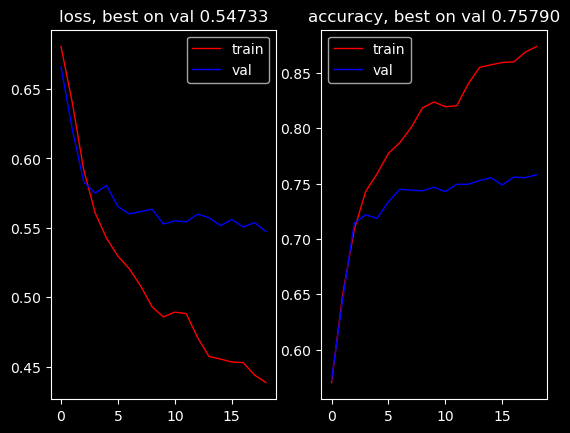

In [32]:
model = GRUModel(embed_dim=300, 
                 hidden_dim=256, 
                 vocab_size=len(vocab),
                 num_layers=1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epoch = 20

history = train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

plot_result(history)

Training epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.43120574206113815
train_accuracy: 0.8839113116264343


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5539690057436625
val_accuracy: 0.7565130392710367


Training epoch 2:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4343235269188881
train_accuracy: 0.8784158378839493


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5476655960083008
val_accuracy: 0.7538919051488241


Training epoch 3:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4253733605146408
train_accuracy: 0.8885261714458466


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5505581299463908
val_accuracy: 0.7592020034790039


Training epoch 4:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.42554475367069244
train_accuracy: 0.8888900727033615


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5502450863520304
val_accuracy: 0.7559128801027933


Training epoch 5:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4231755385796229
train_accuracy: 0.8907188177108765


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5506013631820679
val_accuracy: 0.7559128801027933


Training epoch 6:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4223995804786682
train_accuracy: 0.8913890520731608


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5507386326789856
val_accuracy: 0.7545938293139139


Training epoch 7:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.42125359425942105
train_accuracy: 0.8933613648017248


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5508418877919515
val_accuracy: 0.7532747785250345


Training epoch 8:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4204485168059667
train_accuracy: 0.893686885635058


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5513705611228943
val_accuracy: 0.7525898218154907


Training epoch 9:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4196556384364764
train_accuracy: 0.8948645889759064


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5517966548601786
val_accuracy: 0.7565130392710367


Training epoch 10:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4191439946492513
train_accuracy: 0.8951901098092397


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5516934792200724
val_accuracy: 0.7532238960266113


Training epoch 11:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4185805916786194
train_accuracy: 0.8958411514759064


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.551665186882019
val_accuracy: 0.7545768618583679


Training epoch 12:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41805462290843326
train_accuracy: 0.895860344171524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5523138443628947
val_accuracy: 0.7539258201917013


Training epoch 13:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.417732668419679
train_accuracy: 0.896348625421524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5522751410802206
val_accuracy: 0.7532747785250345


Training epoch 14:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4175649707516034
train_accuracy: 0.8965113858381907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521170298258463
val_accuracy: 0.7545599142710367


Training epoch 15:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4170183117190997
train_accuracy: 0.8969996670881907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5518637895584106
val_accuracy: 0.7565299868583679


Training epoch 16:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4167170499761899
train_accuracy: 0.897325187921524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5516844789187113
val_accuracy: 0.7552618384361267


Training epoch 17:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41694344331820804
train_accuracy: 0.8970188548167547


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5510176022847494
val_accuracy: 0.7565299868583679


Training epoch 18:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4164106299479802
train_accuracy: 0.8974879483381907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5505364139874777
val_accuracy: 0.7591680884361267


Training epoch 19:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41662847995758057
train_accuracy: 0.8976507087548574


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5538662672042847
val_accuracy: 0.7519557476043701


Training epoch 20:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4161076818903287
train_accuracy: 0.897813469171524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5512350797653198
val_accuracy: 0.7565639217694601


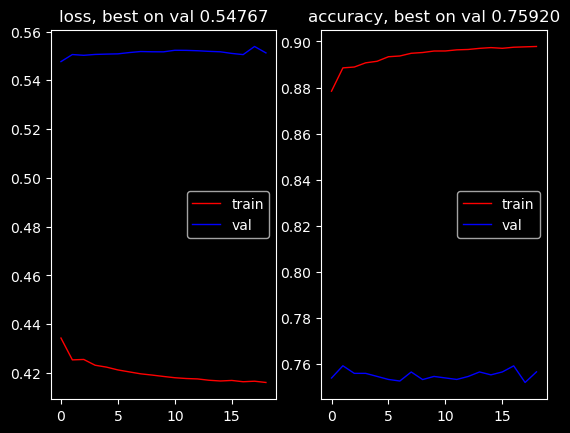

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epoch = 20
history = train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

plot_result(history)

Training epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41572004556655884
train_accuracy: 0.8984645108381907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.551364004611969
val_accuracy: 0.7565469543139139


Training epoch 2:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4156791220108668
train_accuracy: 0.8984645108381907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5515300234158834
val_accuracy: 0.7572149634361267


Training epoch 3:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4156281476219495
train_accuracy: 0.898301750421524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5513721903165182
val_accuracy: 0.7565469543139139


Training epoch 4:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4155925263961156
train_accuracy: 0.898301750421524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5512928366661072
val_accuracy: 0.7565469543139139


Training epoch 5:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4154911736647288
train_accuracy: 0.8986272712548574


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5514145890871683
val_accuracy: 0.7558959126472473


Training epoch 6:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4155084217588107
train_accuracy: 0.8984645108381907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5513865749041239
val_accuracy: 0.7552448709805807


Training epoch 7:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4154570624232292
train_accuracy: 0.8984645108381907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5514334638913473
val_accuracy: 0.7565469543139139


Training epoch 8:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4155171165863673
train_accuracy: 0.8984645108381907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5513838529586792
val_accuracy: 0.7558959126472473


Training epoch 9:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4154411454995473
train_accuracy: 0.898301750421524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5515214006106058
val_accuracy: 0.7558959126472473


Training epoch 10:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4153650030493736
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5515124797821045
val_accuracy: 0.7565469543139139


Training epoch 11:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41541725893815357
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.551747183005015
val_accuracy: 0.7565469543139139


Training epoch 12:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4152347619334857
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5518462260564169
val_accuracy: 0.7558959126472473


Training epoch 13:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4152151842912038
train_accuracy: 0.8986272712548574


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5518871943155924
val_accuracy: 0.7558959126472473


Training epoch 14:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4151736721396446
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5519801576932272
val_accuracy: 0.7565469543139139


Training epoch 15:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4151499619086583
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5518940687179565
val_accuracy: 0.7558959126472473


Training epoch 16:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41507216294606525
train_accuracy: 0.8989527920881907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5518898566563925
val_accuracy: 0.7558959126472473


Training epoch 17:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4150817294915517
train_accuracy: 0.8989527920881907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.551995575428009
val_accuracy: 0.7552448709805807


Training epoch 18:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4150063122312228
train_accuracy: 0.8989527920881907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5519940853118896
val_accuracy: 0.7558959126472473


Training epoch 19:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41501089930534363
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5520646572113037
val_accuracy: 0.7558789451917013


Training epoch 20:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41498973965644836
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5520758827527364
val_accuracy: 0.7558959126472473


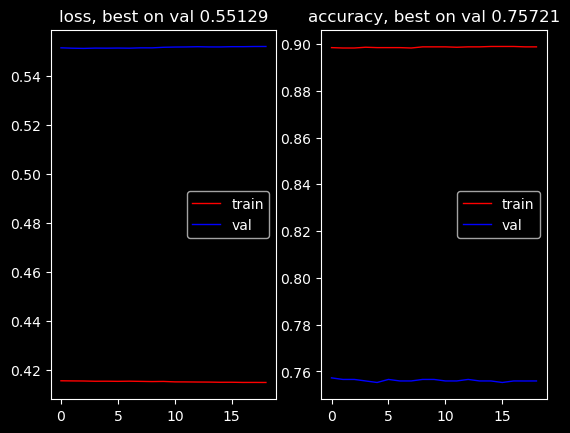

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epoch = 20
history = train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

plot_result(history)

Training epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4149897371729215
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5520983537038168
val_accuracy: 0.7552448709805807


Training epoch 2:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41491849223772687
train_accuracy: 0.8989527920881907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521001815795898
val_accuracy: 0.7558959126472473


Training epoch 3:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41495557129383087
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.552102784315745
val_accuracy: 0.7558959126472473


Training epoch 4:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41493043303489685
train_accuracy: 0.8989527920881907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521047314008077
val_accuracy: 0.7558959126472473


Training epoch 5:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.414875107506911
train_accuracy: 0.8989527920881907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521108508110046
val_accuracy: 0.7558959126472473


Training epoch 6:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41493596881628036
train_accuracy: 0.899278312921524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521118839581808
val_accuracy: 0.7565469543139139


Training epoch 7:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41487346092859906
train_accuracy: 0.8991155525048574


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521091421445211
val_accuracy: 0.7565469543139139


Training epoch 8:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4148278757929802
train_accuracy: 0.8991155525048574


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521090825398763
val_accuracy: 0.7565469543139139


Training epoch 9:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4148432786266009
train_accuracy: 0.8991155525048574


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521141091982523
val_accuracy: 0.7565469543139139


Training epoch 10:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4149366393685341
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521145065625509
val_accuracy: 0.7565469543139139


Training epoch 11:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41487282266219455
train_accuracy: 0.8991155525048574


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521082282066345
val_accuracy: 0.7565469543139139


Training epoch 12:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4148149291674296
train_accuracy: 0.8989527920881907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521149237950643
val_accuracy: 0.7565469543139139


Training epoch 13:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41482288390398026
train_accuracy: 0.899278312921524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521239042282104
val_accuracy: 0.7565469543139139


Training epoch 14:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41489342351754505
train_accuracy: 0.8989527920881907


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521237651507059
val_accuracy: 0.7565469543139139


Training epoch 15:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4148870532711347
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521228512128195
val_accuracy: 0.7565469543139139


Training epoch 16:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4149076317747434
train_accuracy: 0.898790031671524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.552122433980306
val_accuracy: 0.7565469543139139


Training epoch 17:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4148884192109108
train_accuracy: 0.8991155525048574


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521280566851298
val_accuracy: 0.7558959126472473


Training epoch 18:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41479572157065075
train_accuracy: 0.899278312921524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521296660105387
val_accuracy: 0.7558959126472473


Training epoch 19:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.41482527554035187
train_accuracy: 0.899278312921524


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.552124818166097
val_accuracy: 0.7558959126472473


Training epoch 20:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss: 0.4148404275377591
train_accuracy: 0.8991155525048574


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

val_loss: 0.5521209836006165
val_accuracy: 0.7558959126472473


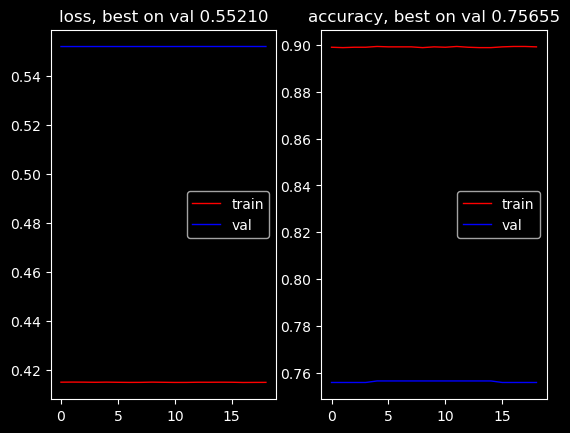

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
num_epoch = 20
history = train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

plot_result(history)

In [ ]:
def predict(model, dataloader) -> list[int]:
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs in tqdm(dataloader, desc=f'Prediction'):
            inputs = inputs.to(device)
            logits = model(inputs)
            preds = logits.argmax(dim=1).tolist()
            predictions.extend(preds)

    return predictions

df_test['target'] = predict(model, test_dataloader)
df_test[['id', 'target']].head()

In [37]:
pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv').head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [38]:
df_test[['id', 'target']].to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
